# This notebook contains model with simple tf-idf only  
- **Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.**



In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import sqlite3
from sqlalchemy import create_engine # database connection

import os
from scipy import stats
from scipy.stats import randint as sp_randint
from scipy.sparse import hstack

import datetime as dt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file </h2>

In [3]:
col_names1 = ['id','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq',
              'abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio',
              'longest_substr_ratio','freq_qid1', 'freq_qid2', 'q1len', 'q2len','q1_n_words', 'q2_n_words',
              'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2']

data = pd.read_csv('final_features.csv',usecols=col_names1)

In [4]:
print(data.shape)
data.head()

(404290, 27)


,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [5]:
train_df1 = pd.read_csv("train.csv",usecols= ['id','question1','question2','is_duplicate'])
 
train_df1['question1'] = train_df1['question1'].apply(lambda x: str(x))
train_df1['question2'] =train_df1['question2'].apply(lambda x: str(x))

In [6]:
print(train_df1.shape)
train_df1.head()

(404290, 4)


,id,question1,question2,is_duplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
train_df1 = train_df1.merge(data, on='id',how='inner')
train_df1.head()

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Sample 100,000 points

In [8]:
sample_df = train_df1.sample(n=100000,random_state = 42)
sample_df.shape

(100000, 30)

In [9]:
y_true = sample_df['is_duplicate']
#train_df1.drop(['Unnamed: 0','is_duplicate'], axis=1, inplace=True)

## 4.2 Train Test Split In [70:30 ] ratio

In [10]:
train_sample_df,test_sample_df, y_train, y_test = train_test_split(sample_df, y_true,stratify=y_true, test_size=0.3)

In [28]:
print("Number of data points in train data :",train_sample_df.shape)
print("Number of data points in test data :",test_sample_df.shape)

Number of data points in train data : (70000, 30)
Number of data points in test data : (30000, 30)


In [29]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6287857142857143 Class 1:  0.3712142857142857
---------- Distribution of output variable in test data ----------
Class 0:  0.6288 Class 1:  0.3712


<h1> 5. Simple Tf-idf featurization </h1>

In [48]:
tfidf_vectorizer1 = TfidfVectorizer(lowercase=False,max_features= 20000)
train_qs1_tf_vec = tfidf_vectorizer1.fit_transform(train_sample_df['question1'])
test_qs1_tf_vec  = tfidf_vectorizer1.transform(test_sample_df['question1'])



In [49]:
print(train_qs1_tf_vec.shape)
print(test_qs1_tf_vec.shape)

(70000, 20000)
(30000, 20000)


In [50]:
tfidf_vectorizer2 = TfidfVectorizer(lowercase=False,max_features= 20000)
train_qs2_tf_vec = tfidf_vectorizer2.fit_transform(train_sample_df['question2'])
test_qs2_tf_vec  = tfidf_vectorizer2.transform(test_sample_df['question2'])

In [51]:
print(train_qs2_tf_vec.shape)
print(test_qs2_tf_vec.shape)

type(train_qs2_tf_vec)

(70000, 20000)
(30000, 20000)


scipy.sparse.csr.csr_matrix

In [52]:
train_tfidf_data1 = hstack((train_qs1_tf_vec,train_qs2_tf_vec))

test_tfidf_data1 = hstack((test_qs1_tf_vec,test_qs2_tf_vec))

train_tfidf_data1.shape #q1 20,000 plus q2 20,000 = 40,000 

(70000, 40000)

In [53]:
train_feature_df = train_sample_df.drop(['id','question1','question2','is_duplicate'], axis=1, inplace=False)
test_feature_df = test_sample_df.drop(['id','question1','question2','is_duplicate'], axis=1, inplace=False)

In [54]:
print(train_feature_df.shape)
train_feature_df.head()

(70000, 26)


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
300533,0.666656,0.499994,0.999967,0.599988,0.777769,0.538457,1.0,1.0,4.0,11.0,...,1,76,52,14,10,8.0,24.0,0.333333,3,1
61270,0.499992,0.428565,0.833319,0.833319,0.666661,0.615380,0.0,1.0,1.0,12.5,...,6,85,70,13,12,8.0,25.0,0.320000,10,2
57261,0.666644,0.499988,0.999980,0.999980,0.874989,0.777769,0.0,1.0,1.0,8.5,...,2,58,46,8,8,4.0,16.0,0.250000,3,1
99041,0.249994,0.249994,0.000000,0.000000,0.124998,0.083333,0.0,0.0,4.0,10.0,...,1,48,51,8,12,0.0,19.0,0.000000,2,0
45048,0.749981,0.599988,0.999980,0.999980,0.888879,0.799992,0.0,1.0,1.0,9.5,...,1,42,49,9,10,8.0,19.0,0.421053,3,1


In [55]:
import scipy

In [56]:
train_feat_matrix = scipy.sparse.csr_matrix(train_feature_df)

test_feat_matrix = scipy.sparse.csr_matrix(test_feature_df)

train_feat_matrix.shape

(70000, 26)

In [57]:
train_x_data1 = hstack((train_feat_matrix,train_tfidf_data1))

test_x_data1 = hstack((test_feat_matrix,test_tfidf_data1))

train_x_data1.shape # 40000 +26 = 40026

(70000, 40026)

In [58]:
X_train = train_x_data1
X_test = test_x_data1


<h2> 5.2 Building a random model (Finding worst-case log-loss) </h2>

In [59]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8884371237214972


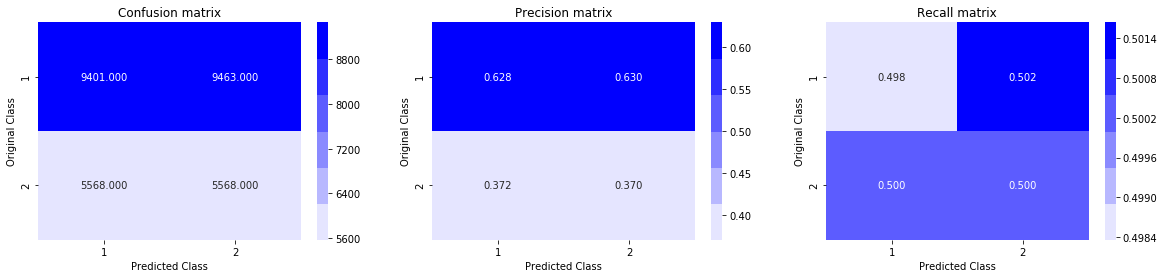

In [60]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 5.3 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.45563494159320417
For values of alpha =  0.0001 The log loss is: 0.4545462918779756
For values of alpha =  0.001 The log loss is: 0.45854899307404845
For values of alpha =  0.01 The log loss is: 0.4549154694304545
For values of alpha =  0.1 The log loss is: 0.4618197003268463
For values of alpha =  1 The log loss is: 0.4906427455351851
For values of alpha =  10 The log loss is: 0.54105536529785


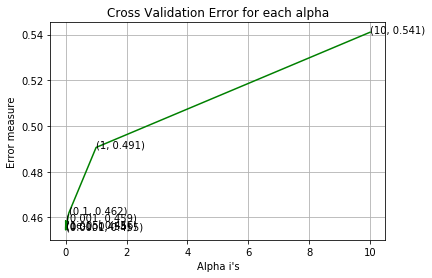

For values of best alpha =  0.0001 The train log loss is: 0.447953512841885
For values of best alpha =  0.0001 The test log loss is: 0.4545462918779756
Total number of data points : 30000


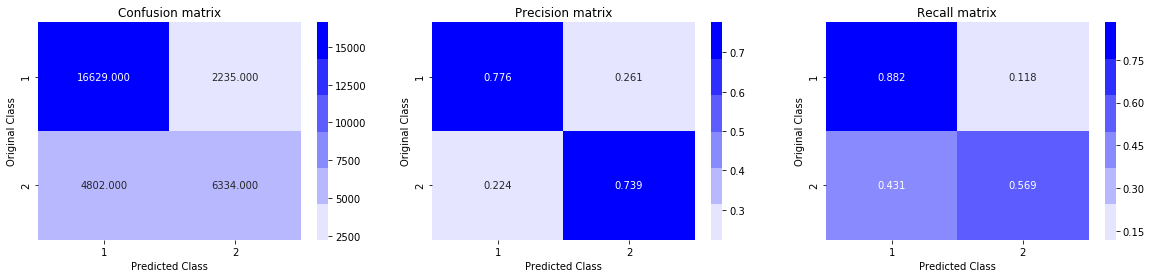

In [61]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 5.4 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.48050903180039234
For values of alpha =  0.0001 The log loss is: 0.49868440387997764
For values of alpha =  0.001 The log loss is: 0.5101535700475534
For values of alpha =  0.01 The log loss is: 0.5079870148692768
For values of alpha =  0.1 The log loss is: 0.5015014133450507
For values of alpha =  1 The log loss is: 0.5831701334334525
For values of alpha =  10 The log loss is: 0.6383040186019401


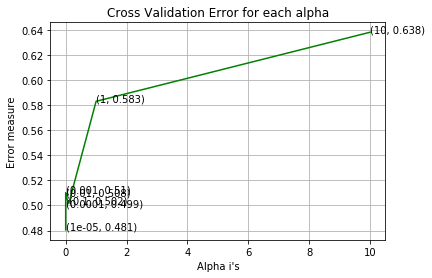

For values of best alpha =  1e-05 The train log loss is: 0.468262471931552
For values of best alpha =  1e-05 The test log loss is: 0.48050903180039234
Total number of data points : 30000


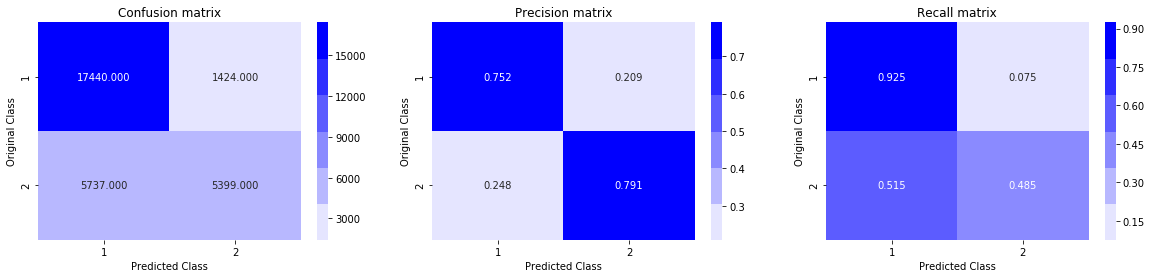

In [62]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Simple Tf-idf features had slight improvement over tf-idf weighted W2v, but nothing major.

# Observations

| Featurization |Algorithm | Test log loss |
|--------------|:-------------|:-------------:|
| Tf-idf w2v  | Logistic Regression | 0.51161|
| Tf-Idf w2v  | Linear SVM  |  0.48642|
| Tf-Idf w2v  | XGBoost  |  0.35399|
| Tf-Idf W2V  | Tuned XGBoost  | 0.34264|
||||
| Tf-Idf  | Logistic Regression      |    0.45454   |
| Tf-Idf  | Linear SVM     |  0.48050   |

